In [1]:
import time
import random
from tqdm import tqdm , trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
 
import torch
from torch import nn, optim, Tensor
 
from torch_sparse import SparseTensor, matmul
 
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [6]:
movie_path = '../data/ml-1m/movies.csv'
rating_path = '../data/ml-1m/ratings.csv'

In [7]:
def load_node_csv(path, index_col):
    """
    Args:
        path (str): 数据集路径
        index_col (str): 数据集文件里的列索引
    Returns:
        dict: 列号和用户ID的索引、列好和电影ID的索引
    """
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}  # enumerate()索引函数,默认索引从0开始
    return mapping


In [8]:
user_mapping = load_node_csv(rating_path, index_col='userId')
movie_mapping = load_node_csv(movie_path, index_col='movieId')
## movieId ：index
## userId ：index

In [9]:
print(len(user_mapping))

6040


In [10]:
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    """
    Args:
        path (str): 数据集路径
        src_index_col (str): 用户列名
        src_mapping (dict): 行号和用户ID的映射
        dst_index_col (str): 电影列名
        dst_mapping (dict): 行号和电影ID的映射
        link_index_col (str): 交互的列名
        rating_threshold (int, optional): 决定选取多少评分交互的阈值，设置为4分
    Returns:
        torch.Tensor: 2*N的用户电影交互节点图
    """
    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold  # 将数组转化为tensor张量
    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
 
    return torch.tensor(edge_index)

In [11]:
edge_index = load_edge_csv(
    rating_path,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='movieId',
    dst_mapping=movie_mapping,
    link_index_col='rating',
    rating_threshold=4,
)

In [12]:
num_users, num_movies = len(user_mapping), len(movie_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]  # 所有索引
 
train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)  # 将数据集划分成80:10的训练集:测试集
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)  # 将测试集划分成10:10的验证集:测试集,最后的比例就是80:10:10
 

In [13]:
train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [14]:

Num_train_nodes = num_users+num_movies
print(Num_train_nodes)
Num_val_nodes = num_users+num_movies
print(Num_val_nodes)
print(num_users)
print(num_movies)

9923
9923
6040
3883


In [15]:

train_sparse_edge_index = SparseTensor.from_edge_index(
    train_edge_index,
    sparse_sizes=(Num_train_nodes, Num_train_nodes)
)
print(train_sparse_edge_index)
val_sparse_edge_index = SparseTensor.from_edge_index(val_edge_index,
    sparse_sizes=(Num_val_nodes, Num_val_nodes)
 )
print(val_sparse_edge_index)

SparseTensor(row=tensor([   0,    0,    0,  ..., 6039, 6039, 6039]),
             col=tensor([   0,   47,  148,  ..., 3602, 3634, 3682]),
             size=(9923, 9923), nnz=460224, density=0.47%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 6039, 6039, 6039]),
             col=tensor([1526, 1949, 3036,  ..., 3042, 3065, 3290]),
             size=(9923, 9923), nnz=57528, density=0.06%)


In [16]:
def sample_mini_batch(batch_size, edge_index):
    print("sample_mini_batch")
    """
    Args:
        batch_size (int): 批大小
        edge_index (torch.Tensor): 2*N的边列表
    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    print("edge_index.max:",edge_index.max(dim=1))
   
    edges = structured_negative_sampling(edge_index)
    print("edges_3:",edges[2])
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    print("sample_edges: ",edges)
    batch = edges[:, indices]
    print(batch)
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [17]:
def sample_neg(batch_size, edge_index):
    print("sample_neg")
    edge_index = edge_index.to(device)
    num_nodes = edge_index.size(1)
    user_indices, pos_item_indices = edge_index

    neg_item_indices = torch.empty(0, dtype=torch.int64, device=device)  # 指定数据类型和设备
    for i in range(num_nodes):
        random_index = torch.randint(0, edge_index.size(1), (1,), device=device)
        while random_index.item() == edge_index[1, i].item():
            random_index = torch.randint(0, edge_index.size(1), (1,), device=device)
        random_element = edge_index[1, random_index]
        neg_item_indices = torch.cat((neg_item_indices, random_element), dim=0)

    edge_index_new = torch.stack((user_indices, pos_item_indices, neg_item_indices), dim=0)
    indices = random.choices([i for i in range(edge_index_new[0].shape[0])], k=batch_size)
    batch = edge_index_new[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices


In [18]:
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=32, K=2, add_self_loops=False, **kwargs):
        """
        Args:
            num_users (int): 用户数量
            num_items (int): 电影数量
            embedding_dim (int, optional): 嵌入维度，设置为64，后续可以调整观察效果
            K (int, optional): 传递层数，设置为3，后续可以调整观察效果
            add_self_loops (bool, optional): 传递时加不加自身节点，设置为不加
        """
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops
 
        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim)  # e_u^0   size: nums_users * embedding_dim
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim)  # e_i^0   size: nums_items * embedding_dim
 
        nn.init.normal_(self.users_emb.weight, std=0.1)  # 从给定均值和标准差的正态分布N(mean, std)中生成值，填充输入的张量或变量
        nn.init.normal_(self.items_emb.weight, std=0.1)
 
    def forward(self, edge_index: SparseTensor):
        """
        Args:
            edge_index (SparseTensor): 邻接矩阵
        Returns:
            tuple (Tensor): e_u%^k, e_u^0, e_i^k, e_i^0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)
 
        emb_0 = torch.cat([self.users_emb.weight, 
                           self.items_emb.weight]) # E^0  size: (nums_items+nums_users) * embedding_dim
        embs = [emb_0]
        emb_k = emb_0
        
 
        # 多尺度扩散
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)
 
        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)  # E^K
 
        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items])  # splits into e_u^K and e_i^K
        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight
 
    def message(self, x_j: Tensor) -> Tensor:
        return x_j
 
    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

In [19]:
model = LightGCN(num_users, num_movies)

In [20]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """
    Args:
        users_emb_final (torch.Tensor): e_u^k
        users_emb_0 (torch.Tensor): e_u^0
        pos_items_emb_final (torch.Tensor): positive e_i^k
        pos_items_emb_0 (torch.Tensor): positive e_i^0
        neg_items_emb_final (torch.Tensor): negative e_i^k
        neg_items_emb_0 (torch.Tensor): negative e_i^0
        lambda_val (float): λ的值
    Returns:
        torch.Tensor: loss值
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2))  # L2 loss L2范数是指向量各元素的平方和然后求平方根
 
    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # 正采样预测分数
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # 负采样预测分数
 
    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss
 
    return loss


In [21]:
def get_user_positive_items(edge_index):
    """为每个用户生成正采样字典
    Args:
        edge_index (torch.Tensor): 2*N的边列表
    Returns:
        dict: 每个用户的正采样字典
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [22]:
def RecallPrecision_ATk(groundTruth, r, k):
    """
    Args:
        groundTruth (list): 每个用户对应电影列表的高评分项
        r (list): 是否向每个用户推荐了前k个电影的列表
        k (intg): 确定要计算精度和召回率的前k个电影
    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [23]:
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k
    Args:
        groundTruth (list): 同上一个函数
        r (list): 同上一个函数
        k (int): 同上一个函数
    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)
 
    test_matrix = torch.zeros((len(r), k))
 
    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()


In [24]:
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """
    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2*N列表
        exclude_edge_indices ([type]): 2*N列表
        k (int): 前多少个电影
    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight
 
    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)
 
    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
 
        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)
 
    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)
 
    # get all unique users in evaluated split
    users = edge_index[0].unique()
 
    test_user_pos_items = get_user_positive_items(edge_index)
 
    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]
 
    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))
 
    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)
 
    return recall, precision, ndcg 

In [25]:
def get_neg( edge_index):
    print("get_neg")
    edge_index = edge_index.to(device)
    num_nodes = edge_index.size(1)
    user_indices, pos_item_indices = edge_index

    neg_item_indices = torch.empty(0, dtype=torch.int64, device=device)  # 指定数据类型和设备
    for i in range(num_nodes):
        random_index = torch.randint(0, edge_index.size(1), (1,), device=device)
        while random_index.item() == edge_index[1, i].item():
            random_index = torch.randint(0, edge_index.size(1), (1,), device=device)
        random_element = edge_index[1, random_index]
        neg_item_indices = torch.cat((neg_item_indices, random_element), dim=0)

    edge_index_new = torch.stack((user_indices, pos_item_indices, neg_item_indices), dim=0)
    indices = random.choices([i for i in range(edge_index_new[0].shape[0])], k=num_nodes)
    batch = edge_index_new[:, indices]
    return batch

In [26]:
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = get_neg(
        edge_index)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]
 
    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()
 
    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)
 
    return loss, recall, precision, ndcg

In [27]:
ITERATIONS = 256
BATCH_SIZE = 32
LR = 1e-3
ITERS_PER_EVAL = 8
ITERS_PER_LR_DECAY = 10
K = 20
LAMBDA = 1e-6

In [28]:
model = model.to(device)
model.train()
 
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)
 
val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

In [29]:
print(train_sparse_edge_index)

SparseTensor(row=tensor([   0,    0,    0,  ..., 6039, 6039, 6039], device='cuda:0'),
             col=tensor([   0,   47,  148,  ..., 3602, 3634, 3682], device='cuda:0'),
             size=(9923, 9923), nnz=460224, density=0.47%)


In [35]:

train_losses = []
val_losses = []
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
 
for iter in trange(ITERATIONS,desc=f"ITERATIONS={iter}"):
    time_start = time.time()
    print("iter: ",iter)
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)
    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_neg(BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device),neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]
 
    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)
 
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
 
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()
 
    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()
    time_end = time.time()
    print(f"Time taken for {time_end - time_start} ")


ITERATIONS=0:   0%|          | 0/256 [00:00<?, ?it/s]

iter:  0
sample_neg
get_neg


ITERATIONS=0:   0%|          | 1/256 [03:23<14:25:51, 203.73s/it]

[Iteration 0/256] train_loss: -0.69361, val_loss: -0.6371, val_recall@20: 0.00622, val_precision@20: 0.00316, val_ndcg@20: 0.00456
Time taken for 203.73258805274963 
iter:  1
sample_neg


ITERATIONS=0:   1%|          | 2/256 [05:03<10:03:09, 142.48s/it]

Time taken for 99.60006999969482 
iter:  2
sample_neg


ITERATIONS=0:   1%|          | 3/256 [06:43<8:39:38, 123.23s/it] 

Time taken for 100.33357262611389 
iter:  3
sample_neg


ITERATIONS=0:   2%|▏         | 4/256 [08:17<7:48:10, 111.47s/it]

Time taken for 93.43873596191406 
iter:  4
sample_neg


ITERATIONS=0:   2%|▏         | 5/256 [09:48<7:15:27, 104.09s/it]

Time taken for 91.01057076454163 
iter:  5
sample_neg


ITERATIONS=0:   2%|▏         | 6/256 [11:18<6:54:37, 99.51s/it] 

Time taken for 90.61724758148193 
iter:  6
sample_neg


ITERATIONS=0:   3%|▎         | 7/256 [12:48<6:39:58, 96.38s/it]

Time taken for 89.9258143901825 
iter:  7
sample_neg


ITERATIONS=0:   3%|▎         | 8/256 [14:20<6:32:21, 94.93s/it]

Time taken for 91.81686663627625 
iter:  8
sample_neg
get_neg


ITERATIONS=0:   4%|▎         | 9/256 [17:30<8:33:43, 124.79s/it]

[Iteration 8/256] train_loss: -0.69155, val_loss: -0.63705, val_recall@20: 0.00615, val_precision@20: 0.00316, val_ndcg@20: 0.00455
Time taken for 190.46601843833923 
iter:  9
sample_neg


ITERATIONS=0:   4%|▍         | 10/256 [19:02<7:49:16, 114.46s/it]

Time taken for 91.3197066783905 
iter:  10
sample_neg


ITERATIONS=0:   4%|▍         | 11/256 [20:33<7:17:56, 107.25s/it]

Time taken for 90.90292811393738 
iter:  11
sample_neg


ITERATIONS=0:   5%|▍         | 12/256 [22:04<6:56:55, 102.52s/it]

Time taken for 91.71695876121521 
iter:  12
sample_neg


ITERATIONS=0:   5%|▌         | 13/256 [23:36<6:41:45, 99.20s/it] 

Time taken for 91.54305458068848 
iter:  13
sample_neg


ITERATIONS=0:   5%|▌         | 14/256 [25:07<6:29:55, 96.67s/it]

Time taken for 90.84359669685364 
iter:  14
sample_neg


ITERATIONS=0:   6%|▌         | 15/256 [26:38<6:21:12, 94.91s/it]

Time taken for 90.80653262138367 
iter:  15
sample_neg


ITERATIONS=0:   6%|▋         | 16/256 [28:08<6:14:06, 93.53s/it]

Time taken for 90.30724000930786 
iter:  16
sample_neg
get_neg


ITERATIONS=0:   7%|▋         | 17/256 [31:19<8:09:36, 122.92s/it]

[Iteration 16/256] train_loss: -0.69318, val_loss: -0.6371, val_recall@20: 0.00617, val_precision@20: 0.00314, val_ndcg@20: 0.00456
Time taken for 191.26549291610718 
iter:  17
sample_neg


ITERATIONS=0:   7%|▋         | 18/256 [32:50<7:29:36, 113.35s/it]

Time taken for 91.07648491859436 
iter:  18
sample_neg


ITERATIONS=0:   7%|▋         | 19/256 [34:22<7:01:32, 106.72s/it]

Time taken for 91.28219389915466 
iter:  19
sample_neg


ITERATIONS=0:   8%|▊         | 20/256 [35:52<6:40:51, 101.91s/it]

Time taken for 90.71179056167603 
iter:  20
sample_neg


ITERATIONS=0:   8%|▊         | 21/256 [37:22<6:24:56, 98.28s/it] 

Time taken for 89.81646919250488 
iter:  21
sample_neg


ITERATIONS=0:   9%|▊         | 22/256 [38:53<6:14:38, 96.06s/it]

Time taken for 90.88170170783997 
iter:  22
sample_neg


ITERATIONS=0:   9%|▉         | 23/256 [40:23<6:06:33, 94.39s/it]

Time taken for 90.47923445701599 
iter:  23
sample_neg


ITERATIONS=0:   9%|▉         | 24/256 [41:55<6:01:20, 93.45s/it]

Time taken for 91.26021957397461 
iter:  24
sample_neg
get_neg


ITERATIONS=0:  10%|▉         | 25/256 [45:05<7:51:27, 122.46s/it]

[Iteration 24/256] train_loss: -0.69282, val_loss: -0.63697, val_recall@20: 0.00601, val_precision@20: 0.00308, val_ndcg@20: 0.00446
Time taken for 190.11965894699097 
iter:  25
sample_neg


ITERATIONS=0:  10%|█         | 26/256 [46:36<7:13:43, 113.15s/it]

Time taken for 91.4311785697937 
iter:  26
sample_neg


ITERATIONS=0:  11%|█         | 27/256 [48:07<6:46:27, 106.50s/it]

Time taken for 90.97624659538269 
iter:  27
sample_neg


ITERATIONS=0:  11%|█         | 28/256 [49:37<6:26:07, 101.61s/it]

Time taken for 90.2177095413208 
iter:  28
sample_neg


ITERATIONS=0:  11%|█▏        | 29/256 [51:08<6:12:02, 98.34s/it] 

Time taken for 90.70212292671204 
iter:  29
sample_neg


ITERATIONS=0:  12%|█▏        | 30/256 [52:39<6:01:34, 95.99s/it]

Time taken for 90.52137041091919 
iter:  30
sample_neg


ITERATIONS=0:  12%|█▏        | 31/256 [54:09<5:53:11, 94.19s/it]

Time taken for 89.96693634986877 
iter:  31
sample_neg


ITERATIONS=0:  12%|█▎        | 32/256 [55:40<5:48:24, 93.32s/it]

Time taken for 91.30623936653137 
iter:  32
sample_neg
get_neg


ITERATIONS=0:  13%|█▎        | 33/256 [58:50<7:35:10, 122.47s/it]

[Iteration 32/256] train_loss: -0.69366, val_loss: -0.637, val_recall@20: 0.00605, val_precision@20: 0.00311, val_ndcg@20: 0.00448
Time taken for 190.47907543182373 
iter:  33
sample_neg


ITERATIONS=0:  13%|█▎        | 34/256 [1:00:21<6:58:17, 113.05s/it]

Time taken for 91.07049322128296 
iter:  34
sample_neg


ITERATIONS=0:  14%|█▎        | 35/256 [1:01:52<6:31:22, 106.25s/it]

Time taken for 90.39850163459778 
iter:  35
sample_neg


ITERATIONS=0:  14%|█▍        | 36/256 [1:03:27<6:16:53, 102.79s/it]

Time taken for 94.69468808174133 
iter:  36
sample_neg


ITERATIONS=0:  14%|█▍        | 37/256 [1:05:07<6:13:04, 102.21s/it]

Time taken for 100.87957286834717 
iter:  37
sample_neg


ITERATIONS=0:  15%|█▍        | 38/256 [1:06:46<6:07:54, 101.26s/it]

Time taken for 99.02451062202454 
iter:  38
sample_neg


ITERATIONS=0:  15%|█▌        | 39/256 [1:08:27<6:04:55, 100.90s/it]

Time taken for 100.06088709831238 
iter:  39
sample_neg


ITERATIONS=0:  16%|█▌        | 40/256 [1:10:04<5:59:56, 99.98s/it] 

Time taken for 97.83984303474426 
iter:  40
sample_neg
get_neg


ITERATIONS=0:  16%|█▌        | 41/256 [1:13:46<8:09:01, 136.47s/it]

[Iteration 40/256] train_loss: -0.69294, val_loss: -0.63699, val_recall@20: 0.00616, val_precision@20: 0.00311, val_ndcg@20: 0.00452
Time taken for 221.60909032821655 
iter:  41
sample_neg


ITERATIONS=0:  16%|█▋        | 42/256 [1:15:34<7:36:12, 127.91s/it]

Time taken for 107.92516231536865 
iter:  42
sample_neg


ITERATIONS=0:  17%|█▋        | 43/256 [1:17:21<7:11:44, 121.62s/it]

Time taken for 106.93465280532837 
iter:  43
sample_neg


ITERATIONS=0:  17%|█▋        | 44/256 [1:19:11<6:57:41, 118.21s/it]

Time taken for 110.27441573143005 
iter:  44
sample_neg


ITERATIONS=0:  18%|█▊        | 45/256 [1:20:58<6:43:24, 114.71s/it]

Time taken for 106.54109740257263 
iter:  45
sample_neg


ITERATIONS=0:  18%|█▊        | 46/256 [1:22:40<6:28:18, 110.95s/it]

Time taken for 102.15458178520203 
iter:  46
sample_neg


ITERATIONS=0:  18%|█▊        | 47/256 [1:24:17<6:12:14, 106.86s/it]

Time taken for 97.34426689147949 
iter:  47
sample_neg


ITERATIONS=0:  19%|█▉        | 48/256 [1:26:07<6:13:34, 107.76s/it]

Time taken for 109.85327982902527 
iter:  48
sample_neg
get_neg


ITERATIONS=0:  19%|█▉        | 49/256 [1:30:09<8:31:09, 148.16s/it]

[Iteration 48/256] train_loss: -0.69244, val_loss: -0.63692, val_recall@20: 0.0061, val_precision@20: 0.00308, val_ndcg@20: 0.00452
Time taken for 242.42915725708008 
iter:  49
sample_neg


ITERATIONS=0:  20%|█▉        | 50/256 [1:31:51<7:40:10, 134.03s/it]

Time taken for 101.06172060966492 
iter:  50
sample_neg


ITERATIONS=0:  20%|█▉        | 51/256 [1:33:32<7:04:58, 124.38s/it]

Time taken for 101.86023449897766 
iter:  51
sample_neg


ITERATIONS=0:  20%|██        | 52/256 [1:35:35<7:01:24, 123.94s/it]

Time taken for 122.91611671447754 
iter:  52
sample_neg


ITERATIONS=0:  21%|██        | 53/256 [1:37:41<7:01:24, 124.55s/it]

Time taken for 125.97955918312073 
iter:  53
sample_neg


ITERATIONS=0:  21%|██        | 54/256 [1:39:45<6:58:46, 124.39s/it]

Time taken for 124.00787949562073 
iter:  54
sample_neg


ITERATIONS=0:  21%|██▏       | 55/256 [1:41:45<6:52:12, 123.05s/it]

Time taken for 119.92042231559753 
iter:  55
sample_neg


ITERATIONS=0:  22%|██▏       | 56/256 [1:43:49<6:51:20, 123.40s/it]

Time taken for 124.22913241386414 
iter:  56
sample_neg
get_neg


ITERATIONS=0:  22%|██▏       | 57/256 [1:48:17<9:12:20, 166.53s/it]

[Iteration 56/256] train_loss: -0.69306, val_loss: -0.6369, val_recall@20: 0.00606, val_precision@20: 0.00312, val_ndcg@20: 0.00452
Time taken for 267.1745193004608 
iter:  57
sample_neg


ITERATIONS=0:  23%|██▎       | 58/256 [1:50:28<8:35:10, 156.12s/it]

Time taken for 131.8043565750122 
iter:  58
sample_neg


ITERATIONS=0:  23%|██▎       | 59/256 [1:52:35<8:03:30, 147.26s/it]

Time taken for 126.59720158576965 
iter:  59
sample_neg


ITERATIONS=0:  23%|██▎       | 60/256 [1:54:49<7:48:26, 143.40s/it]

Time taken for 134.38647055625916 
iter:  60
sample_neg


ITERATIONS=0:  24%|██▍       | 61/256 [1:56:33<7:07:24, 131.51s/it]

Time taken for 103.77242493629456 
iter:  61
sample_neg


ITERATIONS=0:  24%|██▍       | 62/256 [1:58:14<6:35:02, 122.18s/it]

Time taken for 100.40516328811646 
iter:  62
sample_neg


ITERATIONS=0:  25%|██▍       | 63/256 [1:59:54<6:12:27, 115.79s/it]

Time taken for 100.8893973827362 
iter:  63
sample_neg


ITERATIONS=0:  25%|██▌       | 64/256 [2:01:35<5:55:35, 111.12s/it]

Time taken for 100.21790313720703 
iter:  64
sample_neg
get_neg


ITERATIONS=0:  25%|██▌       | 65/256 [2:05:03<7:26:18, 140.20s/it]

[Iteration 64/256] train_loss: -0.69368, val_loss: -0.6369, val_recall@20: 0.00606, val_precision@20: 0.00312, val_ndcg@20: 0.00455
Time taken for 208.05636429786682 
iter:  65
sample_neg


ITERATIONS=0:  26%|██▌       | 66/256 [2:06:42<6:45:28, 128.05s/it]

Time taken for 99.67911744117737 
iter:  66
sample_neg


ITERATIONS=0:  26%|██▌       | 67/256 [2:08:22<6:16:36, 119.56s/it]

Time taken for 99.73749017715454 
iter:  67
sample_neg


ITERATIONS=0:  27%|██▋       | 68/256 [2:10:02<5:56:20, 113.73s/it]

Time taken for 100.11913657188416 
iter:  68
sample_neg


ITERATIONS=0:  27%|██▋       | 69/256 [2:11:43<5:41:48, 109.67s/it]

Time taken for 100.21194076538086 
iter:  69
sample_neg


ITERATIONS=0:  27%|██▋       | 70/256 [2:13:22<5:30:18, 106.55s/it]

Time taken for 99.26261115074158 
iter:  70
sample_neg


ITERATIONS=0:  28%|██▊       | 71/256 [2:15:03<5:23:47, 105.02s/it]

Time taken for 101.43558073043823 
iter:  71
sample_neg


ITERATIONS=0:  28%|██▊       | 72/256 [2:16:48<5:21:40, 104.89s/it]

Time taken for 104.61345410346985 
iter:  72
sample_neg
get_neg


ITERATIONS=0:  29%|██▊       | 73/256 [2:21:03<7:37:44, 150.08s/it]

[Iteration 72/256] train_loss: -0.69377, val_loss: -0.63694, val_recall@20: 0.00607, val_precision@20: 0.00312, val_ndcg@20: 0.00455
Time taken for 255.51115655899048 
iter:  73
sample_neg


ITERATIONS=0:  29%|██▉       | 74/256 [2:23:04<7:08:06, 141.13s/it]

Time taken for 120.24732851982117 
iter:  74
sample_neg


ITERATIONS=0:  29%|██▉       | 75/256 [2:25:07<6:49:59, 135.91s/it]

Time taken for 123.7266788482666 
iter:  75
sample_neg


ITERATIONS=0:  30%|██▉       | 76/256 [2:27:10<6:36:01, 132.01s/it]

Time taken for 122.91079807281494 
iter:  76
sample_neg


ITERATIONS=0:  30%|███       | 77/256 [2:29:16<6:28:16, 130.15s/it]

Time taken for 125.79436135292053 
iter:  77
sample_neg


ITERATIONS=0:  30%|███       | 78/256 [2:31:11<6:12:33, 125.58s/it]

Time taken for 114.92496705055237 
iter:  78
sample_neg


ITERATIONS=0:  31%|███       | 79/256 [2:33:12<6:06:37, 124.28s/it]

Time taken for 121.25332379341125 
iter:  79
sample_neg


ITERATIONS=0:  31%|███▏      | 80/256 [2:35:16<6:04:21, 124.21s/it]

Time taken for 124.0469822883606 
iter:  80
sample_neg
get_neg


ITERATIONS=0:  32%|███▏      | 81/256 [2:39:04<7:32:43, 155.22s/it]

[Iteration 80/256] train_loss: -0.69395, val_loss: -0.63693, val_recall@20: 0.0061, val_precision@20: 0.00317, val_ndcg@20: 0.00455
Time taken for 227.56487035751343 
iter:  81
sample_neg


ITERATIONS=0:  32%|███▏      | 82/256 [2:41:01<6:57:00, 143.80s/it]

Time taken for 117.14409160614014 
iter:  82
sample_neg


ITERATIONS=0:  32%|███▏      | 83/256 [2:43:07<6:38:57, 138.37s/it]

Time taken for 125.70948100090027 
iter:  83
sample_neg


ITERATIONS=0:  33%|███▎      | 84/256 [2:45:13<6:26:31, 134.83s/it]

Time taken for 126.5772967338562 
iter:  84
sample_neg


ITERATIONS=0:  33%|███▎      | 85/256 [2:46:54<5:54:50, 124.50s/it]

Time taken for 100.40097093582153 
iter:  85
sample_neg


ITERATIONS=0:  34%|███▎      | 86/256 [2:48:33<5:31:16, 116.92s/it]

Time taken for 99.23041772842407 
iter:  86
sample_neg


ITERATIONS=0:  34%|███▍      | 87/256 [2:50:13<5:15:27, 112.00s/it]

Time taken for 100.51111245155334 
iter:  87
sample_neg


ITERATIONS=0:  34%|███▍      | 88/256 [2:52:02<5:10:54, 111.04s/it]

Time taken for 108.79331684112549 
iter:  88
sample_neg
get_neg


ITERATIONS=0:  35%|███▍      | 89/256 [2:56:12<7:05:09, 152.75s/it]

[Iteration 88/256] train_loss: -0.69341, val_loss: -0.63677, val_recall@20: 0.00606, val_precision@20: 0.00314, val_ndcg@20: 0.00451
Time taken for 250.07357716560364 
iter:  89
sample_neg


ITERATIONS=0:  35%|███▍      | 89/256 [2:57:25<5:32:54, 119.61s/it]


KeyboardInterrupt: 

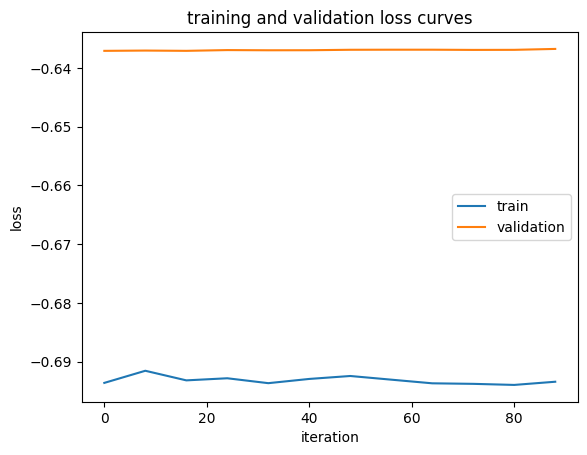

In [36]:

iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()